In [8]:
import scanpy as sc
import pandas as pd
import numpy as np
import anndata
import scipy
import matplotlib.pyplot as plt
import matplotlib as mpl
# enables correct plotting of text
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42 

import seaborn as sns

import warnings
warnings.simplefilter("ignore", UserWarning)

In [9]:
# Configure rpy2 to Use the Correct R Installation:
import os
os.environ['R_HOME'] = '/software/cellgen/team205/kk18/envs/generic_env/lib/R'
# check
from rpy2.rinterface_lib import openrlib
print(openrlib.R_HOME)

/software/cellgen/team205/kk18/envs/generic_env/lib/R


In [10]:
import milopy.core as milo
import milopy.plot as milopl
import milopy.utils

In [11]:
sc.settings.set_figure_params(dpi=80)

In [12]:
import importlib.util
import sys
spec = importlib.util.spec_from_file_location("module.name", "/nfs/team205/kk18/function/python/utils.py")
utils = importlib.util.module_from_spec(spec)
sys.modules["module.name"] = utils
spec.loader.exec_module(utils)

In [13]:
figdir = '/nfs/team205/heart/fetal_ms_figures/raw_plots_kk/Aug2024'
table_dir = '/nfs/team205/heart/fetal_ms_figures/tables/Aug2024'

# Read in adata

In [7]:
# atlas
adata = sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/trisomy21/Euploid_T21Hearts_Aug2024_sel_subsampled-per-cellstate-donor_cells-in-sig-nhoods-sfdr0p1.h5ad')
adata

AnnData object with n_obs × n_vars = 14846 × 36601
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'region', 'age', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score', 'donor_by_library-prep', 'multiplexed', 'SOC | status', 'SOC | log_prob_singleton', 'SOC | log_prob_doublet', 'batch_key', '_scvi_batch', 'FACSgate', 'fine_grain', 'mid_grain', 'coarse_grain', 'sex', 'week', 'trimester', 'heart_or_greatvessels', 'cycling', 'S_score', 'G2M_score', 'phase', '_scvi_labels', 'stress_score', 'hb1_score', 'euploid_or_t21', 'donor_type', 'region_finest', 'flushed', 'scrublet_leiden', 'cluster_scrublet_score', 'leiden_scVI_0.1', 'leiden

# Annotate nhoods

In [14]:
milopy.utils.annotate_nhoods(adata, anno_col='fine_grain_merged')

Text(0.5, 0, 'celltype fraction')

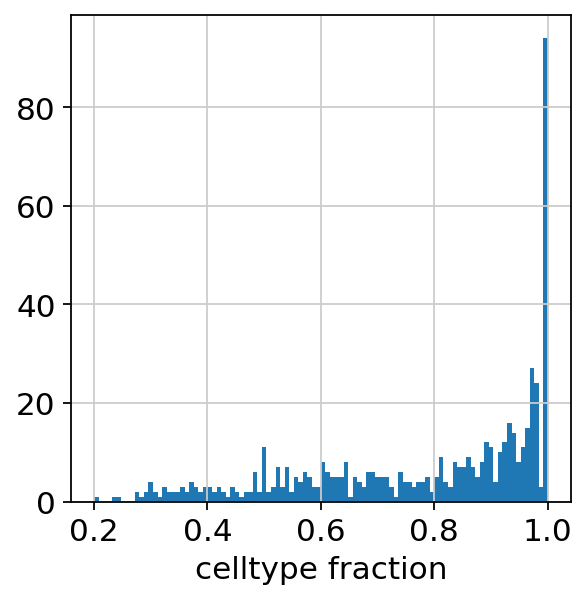

In [15]:
plt.hist(adata.uns['nhood_adata'].obs["nhood_annotation_frac"],bins=100);
plt.xlabel("celltype fraction")

In [16]:
# We can see that for the majority of neighbourhoods, almost all cells have the same neighbourhood. We can rename neighbourhoods where less than 60% of the cells have the top label as "Mixed"
adata.uns['nhood_adata'].obs["nhood_annotation"] = adata.uns['nhood_adata'].obs["nhood_annotation"].astype('str')
adata.uns['nhood_adata'].obs.loc[adata.uns['nhood_adata'].obs["nhood_annotation_frac"] < 0.6, "nhood_annotation"] = "Mixed"

# Pseudobulk: nhood-by-gene adata

* With reassigned nhoods

In [19]:
adata.uns['nhood_adata'].obs['deg_group'].value_counts()

deg_group
trisomy21    339
euploid      238
Name: count, dtype: int64

In [20]:
%%time
# first take sum
# with raw gene counts
# np.dot of gene-by-cell and cell-by-nhood (boolean) will make gene-by-nhood with summed counts
X = adata.X.todense().T.copy() # gene-by-cell
Y = adata.obsm['nhoods_reassigned'].todense().copy()
Z = np.matmul(X,Y) # gene-by-nhood

# prepare anndata
adata_nhood = anndata.AnnData(
    X=np.array(Z).T,
    obs=adata.uns['nhood_adata'].obs[['index_cell','logFC','PValue','FDR','SpatialFDR','nhood_annotation','deg_group']].copy(),
    var=adata.var.copy()
)
adata_nhood

CPU times: user 18.1 s, sys: 3.45 s, total: 21.6 s
Wall time: 22.6 s


AnnData object with n_obs × n_vars = 577 × 36601
    obs: 'index_cell', 'logFC', 'PValue', 'FDR', 'SpatialFDR', 'nhood_annotation', 'deg_group'
    var: 'gene_id', 'gene_name_scRNA-0-0', 'feature_type-1', 'mt-1', 'ribo-1', 'n_cells_by_counts-1', 'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'log1p_total_counts-1', 'gene_name_GenomicFeatures', 'gene_biotype_GenomicFeatures', 'gene_seq_start_GenomicFeatures', 'gene_seq_end_GenomicFeatures', 'seq_name_GenomicFeatures', 'seq_strand_GenomicFeatures', 'seq_coord_system_GenomicFeatures', 'description_GenomicFeatures', 'gene_id_version_GenomicFeatures', 'canonical_transcript_GenomicFeatures', 'gene_name'

In [21]:
# save
adata_nhood.write('/nfs/team205/heart/anndata_objects/Foetal/trisomy21/Euploid_T21Hearts_Aug2024_sel_subsampled-per-cellstate-donor_cells-in-sig-nhoods-sfdr0p1_pseudobulked-nhood-reassigned-sum_finegrain.h5ad')